In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
% cd './drive/My Drive/socialmind'

Mounted at /content/drive/
/content/drive/My Drive/socialmind


In [ ]:
!pip install torch torchvision
!pip install opencv-contrib-python
!pip install mediapipe
!pip install Pillow
!pip install ffmpeg moviepy

In [3]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import sys
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# audio
import 

import img_utils
import time_seq_utils
# import age_gender_utils

# gaze direction (https://github.com/Ahmednull/L2CS-Net) # NO LICENSE
sys.path.append("./gaze_direction")
sys.path.append("./gaze_direction/face-detection")
sys.path.append("./gaze_direction/face-detection/face_detection")
from gaze_direction.gaze import Gaze

# display images on colab
from google.colab.patches import cv2_imshow

In [ ]:
if __name__ == '__main__':
  
  main_dir = './drive/My Drive/socialmind'
  % cd main_dir
  out_dir = './videos/tracker/'
  os.makedirs(out_dir, exist_ok=True)
  # ---------- constants ------------ #
  T_STATS_RECT = 5 # second to collect information regarding adult or child location 
  T_STATS_HANDS = 1 # second to collect information regarding hands closeness
  T_STATS_MOUTH = 0.5 # second to collect information regarding mouth movement
  # load YOLO detector model
  # yolo_model = img_utils.load_model()
  gaze_model = Gaze()
  segmentation_model = img_utils.load_segmentation_model()
  # load age_gender model
  # age_instance = age_gender_utils.AgeGender('.')
  video_types = ['videos/*.MOV', 'videos/*.mp4']
  videos_grabbed = list(itertools.chain(*[glob.glob(v) for v in video_types]))
  for video in videos_grabbed:
    if not video[-12:] == 'yt_video.mp4':
    # if not video[-5:] == 'K.mp4':
      continue
    print('processing video: ', video)
    if not os.path.isfile(video):
      continue
    try:
      if cap.isOpened():
        cap.release()
    except:
      print("capture is closed")
  
    # extract audio from video
    # ----------video params---------------- #
    print(video)
    cap, fps, im_size, font_size, font_stroke = img_utils.get_video_params(video)
    time_bin = 1/fps
    width, height = im_size[0], im_size[1]
    out_name = f"{out_dir}{video.split('/')[-1][:-4]}_AI.mp4"
    output_video = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc(*'MP4V'), fps, im_size)
    # -------------------------- #

    # ----------- variables and class instantiation --------- #
    i, timer = 0, 0
    out_df = pd.DataFrame({'time': [], 'adult_loc': [], 'child_loc': [], 'adult_hands_loc': [], 'child_hands_loc': [], 'adult_mouth_dist': [], 'child_mouth_dist': []})
    adult_xmins_seq, child_xmins_seq, child_hands_seq, adult_hands_seq, child_fingers_seq, adult_fingers_seq = [], [], [], [], [], []
    child_yaw_seq, child_pitch_seq, adult_yaw_seq, adult_pitch_seq, child_mouth_seq, adult_mouth_seq = [], [], [], [], [], []
    # interaction #
    is_hands_interaction = None
    is_eye_contact = None
    # ----------- variables and class instantiation --------- #
    HandInteraction = time_seq_utils.HandInteraction(fps, width, height)
    
    # ---------iterate over frames--------- #
    while(cap.isOpened()):
      success, img = cap.read()
      if not success:
        print("No more frames to process.")
        # If loading a video, use 'break' instead of 'continue'.
        break
      adult_loc, child_loc, adult_hands_loc, child_hands_loc, adult_mouth_dist, child_mouth_dist = None, None, None, None, None, None
      imgRGB = img_utils.img_preprocess(img, vid_ext=video[:-3])
      orig_img_rgb = imgRGB.copy()

      # instance segmentation (only for person), bboxes for all objects 
      imgRGB, masks, boxes, labels, scores, found_person_labels = img_utils.get_segments(orig_img_rgb, imgRGB, segmentation_model)

      # detector_results = yolo_model(imgRGB)
      
      person_df = img_utils.get_person_bbxs(boxes, labels, scores) # return None or at least 2 bboxes
      # break
      if person_df is not None: # at least 2 person found
        # ------------ face-based age estimation------------ #
        # faceBoxes = age_instance.face_detector(imgRGB)
        # if faceBoxes:
          # ages, genders = age_instance.age_estimator(imgRGB, faceBoxes)
          # find rects of adult and child
          # child_rect_idx, adult_rect_idx = match_rect_to_person(person_df, faceBoxes, ages)
        # -------------------------------------------------- #
        
        # find adult and child based on diagonal length
        child_rect_idx, adult_rect_idx = img_utils.match_rect_to_person(person_df)
        adult_loc, child_loc = person_df.iloc[adult_rect_idx].values[:4], person_df.iloc[child_rect_idx].values[:4]
        adult_xmins_seq.append(person_df.iloc[adult_rect_idx]['xmin'])
        child_xmins_seq.append(person_df.iloc[child_rect_idx]['xmin'])

        if i % (T_STATS_RECT*fps) == 0: # statistics runs for every T_STATS sec
          adult_loc, child_loc = time_seq_utils.get_accurate_loc(adult_xmins_seq, child_xmins_seq, person_df, adult_rect_idx, child_rect_idx)
          adult_xmins_seq, child_xmins_seq = [], []

        # draw the bounding box and label on the image
        img_utils.draw_rect(imgRGB, adult_loc, font_size, font_stroke, label='adult')
        img_utils.draw_rect(imgRGB, child_loc, font_size, font_stroke, label='child')

        # --------------- find gaze and face landmraks ------------- #
        imgRGB, adult_feats, child_feats, face_lmks = gaze_model.find_gaze(orig_img_rgb, imgRGB, adult_loc, child_loc)
        # --------------- process mouth distance from face landmraks ------------- #
        if face_lmks:
          child_lmks, adult_lmks = img_utils.match_face_lmks_to_person(face_lmks, adult_loc, child_loc, orig_img_rgb.shape)
          adult_mouth_dist, child_mouth_dist = img_utils.get_mouth_dist(adult_lmks, child_lmks, orig_img_rgb.shape)
          adult_mouth_seq.append(adult_mouth_dist), child_mouth_seq.append(child_mouth_dist)
        
        if i % int(T_STATS_MOUTH*fps) == 0: # statistics runs for every T_STATS_MOUTH sec
          is_adult_speaks, is_child_speaks = time_seq_utils.get_speaker_by_mouth(adult_mouth_seq, child_mouth_seq)
          adult_mouth_seq, child_mouth_seq = [], []
          
        if is_adult_speaks:
          cv2.putText(imgRGB, 'adult speaks', (int(width/8), 30), cv2.FONT_HERSHEY_PLAIN, font_size, (255, 0, 0), font_stroke, cv2.LINE_AA)

        if is_child_speaks:
          cv2.putText(imgRGB, 'child speaks', (int(width-width/5), 30), cv2.FONT_HERSHEY_PLAIN, font_size, (0, 0, 255), font_stroke, cv2.LINE_AA)

        # ------------- run hands detector ------------- #
        hands_centers, fingers_tips = img_utils.get_hands_loc(orig_img_rgb, imgRGB)

        if hands_centers is not None:
          # -------------------------- match hands to person ---------------------------- #
          hands_dict, fingers_dict = img_utils.match_hands_to_person_polygon(masks, found_person_labels, adult_loc, child_loc, hands_centers, fingers_tips)
          # hands_dict, fingers_dict = img_utils.match_hands_to_person_diag(adult_loc, child_loc, hands_centers, fingers_tips)
          adult_hands_loc = hands_dict['adult_hands'] if hands_dict['adult_hands'] else None
          child_hands_loc = hands_dict['adult_hands'] if hands_dict['child_hands'] else None

          # ------------- collect fingers info; draw hands labels --------------- #
          adult_fingers, child_fingers = img_utils.collect_and_draw_hands(imgRGB, fingers_dict, hands_dict,\
                                                                                  child_fingers_seq, adult_fingers_seq, font_size, font_stroke)
          adult_fingers_seq += adult_fingers
          child_fingers_seq += child_fingers

          # ------------------- measure hands proximity and eye contact -------------- #
          if i % int(T_STATS_HANDS*fps) == 0:
            is_hands_interaction = HandInteraction.hands_proximity(child_fingers_seq, adult_fingers_seq)
            child_fingers_seq, adult_fingers_seq = [], []
            # -------- # -------- #
            # is_eye_contact = Interaction.gaze_estimation(child_fingers_seq, adult_fingers_seq)
          if is_hands_interaction:
            print('Found interaction')
            cv2.putText(imgRGB, 'Hand Interaction!', (np.max([int(width/2)-40, 0]), int(height/2)), cv2.FONT_HERSHEY_PLAIN, font_size, (255, 255, 0), font_stroke, cv2.LINE_AA)
      
      out_df.loc[-1] = [timer, adult_loc, child_loc, adult_hands_loc, child_hands_loc, adult_mouth_dist, child_mouth_dist]
      out_df.index = out_df.index + 1
      out_df = out_df.sort_index()  # sorting by index
      timer += time_bin
      img = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2BGR)
      output_video.write(img)
      i += 1
      print(i)

      # if i>601:
      #   break
  out_df.to_csv(out_name[:-3]+'csv')
  output_video.release()
  cap.release()



In [19]:
person_df.iloc[child_rect_idx].values[:4]

array([256., 115., 375., 275.])

In [20]:
person_df.iloc[adult_rect_idx].values[:4]

array([101.,  40., 280., 275.])

In [ ]:
child_lmks

In [ ]:
cv2_imshow(imgRGB)

Output hidden; open in https://colab.research.google.com to view.

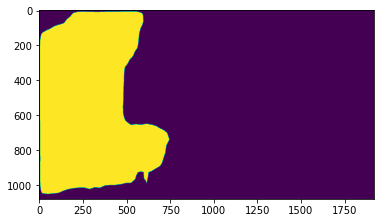

In [ ]:
plt.imshow(masks[0])

In [ ]:
adult_loc

(4.0, 0.0, 780.0, 1064.0)

In [ ]:
mask0 = np.array(masks[0] * 255, dtype='uint8')
border = cv2.copyMakeBorder(mask0, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0 )
contours, hierarchy = cv2.findContours(border, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE, offset=(-1, -1))
cv2.pointPolygonTest(contours[0], (child_loc[0], child_loc[1]), True)

-604.5568625034373

In [ ]:
cv2.drawContours(mask0, contours, -1, (127, 127, 127), 4)
plt.imshow(mask, cmap='Greys_r',  interpolation='none')
plt.show()

In [ ]:
cv2.pointPolygonTest(contours[0], hands_centers[0], False)

1.0

In [ ]:
mask1 = np.array(masks[1] * 255, dtype='uint8')
border = cv2.copyMakeBorder(mask1, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0 )
contours, hierarchy = cv2.findContours(border, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE, offset=(-1, -1))
cv2.pointPolygonTest(contours[0], hands_centers[0], True)

-766.2747549019216

In [ ]:
len(contours[0])

1142

In [ ]:
masks[0].sum()

563063

In [ ]:
masks[1].sum()

350971